In [68]:
import os,sys,requests,numpy,time,pandas,ssl,scipy
import matplotlib.pyplot as plt
import urllib.request
ssl._create_default_https_context = ssl._create_unverified_context
def getRandomN(n,min,max):return numpy.sort((max-min)*numpy.random.random_sample(n)+min)
print('done')

done


In [98]:
image_services = {'MosaicMRF_Albers':'https://ntcfsxopsx1284:6443/arcgis/rest/services/Utilities2/TM2016_CONUS_StandHt/ImageServer',
'MRF_Albers':'https://ntcfsxopsx1284:6443/arcgis/rest/services/Utilities2/TreeMap2016_CONUS_StandHt_mrf/ImageServer',
'MosaicMRF_WebMercator':'https://ntcfsxopsx1284:6443/arcgis/rest/services/Utilities2/TM2016_CONUS_StandHt_WMmosaic/ImageServer',
'MRF_WebMercator':'https://ntcfsxopsx1284:6443/arcgis/rest/services/Utilities2/TreeMap2016_CONUS_StandHt_WM_mrf/ImageServer'
}
# image_services = {'LCMS_Albers':'https://apps.fs.usda.gov/fsgisx01/rest/services/RDW_LandscapeAndWildlife/LCMS_CONUS_Most_Recent_Year_Of_Fast_Loss/ImageServer',
#                   'LCMS_WM':'https://apps.fs.usda.gov/fsgisx01/rest/services/RDW_LandscapeAndWildlife/LCMS_CONUS_Annual_Landcover/ImageServer'}

image_services = {'LCMS_Albers':'https://apps.fs.usda.gov/fsgisx01/rest/services/Utilities2/LCMS_CONUS_Most_Recent_Year_of_Fast_Loss/ImageServer',
                  'LCMS_WebMercator':'https://apps.fs.usda.gov/fsgisx01/rest/services/RDW_LandscapeAndWildlife/LCMS_CONUS_Most_Recent_Year_Of_Fast_Loss/ImageServer'}
service_bounds = [-1.42463587702E7,2604056.207800001,-7264068.770199999,6736796.207800001]

projections = {
    'Albers':102008,
    'WM':3857
}
nTests = 10
exportImage_output_folder = r'X:\03_Outputs\03_Image_Service_Benchmarking\exportImage'
exportImageTable = os.path.join(exportImage_output_folder,'Treemap_ExportImage_Benchmarking_Table_{}.csv'.format(nTests))

In [101]:
def getJSON(call):
    startTime = time.time()
    call_url = urllib.request.urlopen(call)
    data = call_url.read()
    encoding = call_url.info().get_content_charset('utf-8')
    out = json.loads(data.decode(encoding))
    endTime = time.time()
    tDiff = endTime-startTime
    return out,tDiff
# https://ntcfsxopsx1284:6443/arcgis/rest/services/Utilities2/TM2016_CONUS_StandHt/ImageServer/identify?f=json&geometryType=esriGeometryPoint&geometry=%7B%22spatialReference%22%3A%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D%2C%22x%22%3A-11921755.53687916%2C%22y%22%3A4532808.442112485%7D&mosaicRule=%7B%22ascending%22%3Atrue%2C%22mosaicMethod%22%3A%22esriMosaicNorthwest%22%2C%22mosaicOperation%22%3A%22MT_FIRST%22%7D&pixelSize=%7B%22spatialReference%22%3A%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D%2C%22x%22%3A152.87405657041106%2C%22y%22%3A152.87405657041106%7D&returnGeometry=false&returnCatalogItems=true&returnPixelValues=true&maxItemCount=1&processAsMultidimensional=false
#https://ic.imagery1.arcgis.com/arcgis/rest/services/Sentinel2_10m_LandCover/ImageServer/computeHistograms?f=json&geometryType=esriGeometryEnvelope&geometry=%7B%22spatialReference%22%3A%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D%2C%22xmin%22%3A-6439159.676091688%2C%22ymin%22%3A-2036128.75454345%2C%22xmax%22%3A-6321752.400645688%2C%22ymax%22%3A-2018701.1120944342%7D&mosaicRule=%7B%22ascending%22%3Atrue%2C%22mosaicMethod%22%3A%22esriMosaicAttribute%22%2C%22sortValue%22%3Anull%2C%22where%22%3A%22%28Year+%3D+2022%29%22%7D&renderingRule=%7B%22rasterFunction%22%3A%22Cartographic+Renderer+-+Legend+and+Attribute+Table%22%7D&pixelSize=%7B%22x%22%3A76.43702828515632%2C%22y%22%3A76.43702828515632%2C%22spatialReference%22%3A%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D%7D
exportImage_template = '{}/exportImage?f=image&bbox={}&imageSR={}&bboxSR=102100'
identify_template = '{}/identify?f=json&geometryType=esriGeometryPoint&geometry={},{}&sr=102100&returnPixelValues=true&maxItemCount=1&processAsMultidimensional=false'
def getBenchmarkTable(overwrite=False):
    if not os.path.exists(exportImage_output_folder):os.makedirs(exportImage_output_folder)

    if not os.path.exists(exportImageTable) or overwrite:
        out_table = 'Iteration,Bbox'
        for service_name in list(image_services.keys()):
            for projection_name in projections.keys():
                out_table+=',{} Projection-{} Time'.format(service_name,projection_name)
        out_table+='\n'

        for i in range(1,nTests+1):
            xs = getRandomN(2,service_bounds[0],service_bounds[2])
            ys = getRandomN(2,service_bounds[1],service_bounds[3])
            bbox = [str(i) for i in [xs[0],ys[0],xs[1],ys[1]]]
            bbox_comma_delimited = ','.join(bbox)
            bbox_underscore_delimited = '_'.join(bbox)
            # print(bbox)
            time_list = []
            count_lists = []
            for service_name in list(image_services.keys()):
                service_path = image_services[service_name]
                
                # for projection_name in projections.keys():
                #     projection_code = projections[projection_name]
                    

                #     exportImageCall = '{}/exportImage?f=image&bbox={}&imageSR={}&bboxSR=102100'.format(service_path,bbox_comma_delimited,projection_code)
                #     identifyCall = '{}/identify?f=json&geometryType=esriGeometryPoint&geometry={},{}&sr=3857&returnPixelValues=true&maxItemCount=1&processAsMultidimensional=false'.format(service_path,xs[0],ys[0])

                    

                #     exportImageName = os.path.join(exportImage_output_folder,'iteration{}_{}_callProj{}.png'.format(i,service_name,projection_name))
                #     # print(computeHistogramCall)
                #     # print(exportImageName)
                #     # startTime = time.time()
                #     # urllib.request.urlretrieve(exportImageCall, exportImageName)
                #     # endTime = time.time()
                #     # time_list.append(str(endTime-startTime))

                    
                #     # identify_json = getJSON(identifyCall)
                #     # print(identify_json)
                #     # hist_json = getJSON(computeHistogramCall)
                #     # print(hist_json)

                #     # computeHistogramCall = '{}/computeHistograms'.format(service_path)
                #     # computeHistogramCall = 'https://ic.imagery1.arcgis.com/arcgis/rest/services/Sentinel2_10m_LandCover/ImageServer/computeHistograms'
                #     # params = dict(f= 'json',
                #     #         geometryType= 'esriGeometryEnvelope',
                #     #         geometry= {"spatialReference":{"latestWkid":3857,"wkid":102100},"xmin":xs[0],"ymin":ys[0],"xmax":xs[1],"ymax":ys[1]},
                #     #         mosaicRule= {"ascending":'true',"mosaicMethod":"esriMosaicAttribute","sortValue":'null',"where":"(Year = 2022)"},
                #     #         pixelSize= {"x":30,"y":30,"spatialReference":{"latestWkid":3857,"wkid":102100}}
                #     #         )
                #     # params = dict(f= 'json',
                #     #         geometryType= 'esriGeometryEnvelope',
                #     #         geometry= {"spatialReference":{"latestWkid":3857,"wkid":102100},"xmin":-6439159.676091688,"ymin":-2028179.3036017937,"xmax":-6321752.400645688,"ymax":-2026650.5630360905},
                #     #         mosaicRule= {"ascending":True,"mosaicMethod":"esriMosaicAttribute","sortValue":None,"where":"(Year = 2022)"},
                #     #         renderingRule= {"rasterFunction":"Cartographic Renderer - Legend and Attribute Table"},
                #     #         pixelSize= {"x":76.43702828515632,"y":76.43702828515632,"spatialReference":{"latestWkid":3857,"wkid":102100}})
                #     # print(params)
                computeHistogramCall = '{}/computeHistograms?f=json&geometryType=esriGeometryEnvelope&geometry=%7B%22spatialReference%22%3A%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D%2C%22xmin%22%3A{}%2C%22ymin%22%3A{}%2C%22xmax%22%3A{}%2C%22ymax%22%3A{}%7D&pixelSize=%7B%22x%22%3A30%2C%22y%22%3A30%2C%22spatialReference%22%3A%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D%7D'.format(service_path,xs[0],ys[0],xs[0]+100000,ys[0]+100000)
                # resp = requests.get(url=computeHistogramCall)#, json=params)
                # data = resp.json() # Check the JSON Response Content documentation below
                print(computeHistogramCall)
                data,dTime = getJSON(computeHistogramCall)
                print(service_name,data['histograms'][0]['counts'],dTime)
                count_lists.append(data['histograms'][0]['counts'])
            print(list(zip(range(1985,2023),count_lists[0],count_lists[1])))
            out_table+= '{},{},{}\n'.format(i,bbox_underscore_delimited,','.join(time_list))
            print()
            # print(out_table)
            o = open(exportImageTable,'w')
            o.write(out_table)
            o.close()
getBenchmarkTable(overwrite=True)
print('done')

https://apps.fs.usda.gov/fsgisx01/rest/services/Utilities2/LCMS_CONUS_Most_Recent_Year_of_Fast_Loss/ImageServer/computeHistograms?f=json&geometryType=esriGeometryEnvelope&geometry=%7B%22spatialReference%22%3A%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D%2C%22xmin%22%3A-12362817.592186779%2C%22ymin%22%3A5948665.791824907%2C%22xmax%22%3A-12262817.592186779%2C%22ymax%22%3A6048665.791824907%7D&pixelSize=%7B%22x%22%3A30%2C%22y%22%3A30%2C%22spatialReference%22%3A%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D%7D
LCMS_Albers [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 28665, 872, 3040, 3621, 4711, 3335, 1979, 4523, 3018, 8360, 2186, 19217, 7316, 4305, 5220, 4793, 4708, 8396, 3840, 1892, 4589, 2428, 5272, 1518, 1963, 1306, 5142, 5661, 1620, 1000, 1428, 1500, 7634, 2415, 2128, 9314, 40288, 160455] 0.3898351192474365
https://apps.fs.usda.gov/fsgisx01/rest/services/RDW_LandscapeAndWildlife/LCMS_CONUS_Most_Recent_Year_Of_Fast_Loss/ImageServer/computeHistograms?f=json&geometryType=esriG

In [23]:
import json
import urllib.request
urlData = "https://ntcfsxopsx1284:6443/arcgis/rest/services/Utilities2/TM2016_CONUS_StandHt/ImageServer/identify?f=json&geometryType=esriGeometryPoint&geometry=-13596782.109807547,3364025.5268414575&sr=102100&returnPixelValues=true&maxItemCount=1&processAsMultidimensional=false"
webURL = urllib.request.urlopen(urlData)
data = webURL.read()
encoding = webURL.info().get_content_charset('utf-8')
json.loads(data.decode(encoding))

{'objectId': 0,
 'name': 'Pixel',
 'value': 'NoData',
 'location': {'x': -13596782.109807547,
  'y': 3364025.5268414575,
  'spatialReference': {'wkt': 'PROJCS["NAD_1983_Albers",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers"],PARAMETER["False_Easting",0.0],PARAMETER["False_Northing",0.0],PARAMETER["central_meridian",-96.0],PARAMETER["Standard_Parallel_1",29.5],PARAMETER["Standard_Parallel_2",45.5],PARAMETER["latitude_of_origin",23.0],UNIT["Meter",1.0]]'}},
 'properties': {},
 'catalogItems': {'objectIdFieldName': 'OBJECTID',
  'geometryType': 'esriGeometryPolygon',
  'spatialReference': {'wkt': 'PROJCS["NAD_1983_Albers",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers"],PARAMETER["False_Easting",0.0],PARAMETER["F

In [70]:
print(time.time())

1684882300.2222278


['MosaicMRF_Albers Projection-Albers Time', 'MosaicMRF_Albers Projection-WM Time']
Mean diff: 0.0060987286567688
MAE: 0.05414715909957886
RMSE: 0.21071999724245802
STDev: 0.21063172303010916
Ttest_indResult(statistic=0.572574656657278, pvalue=0.5469061876247505)
['MRF_Albers Projection-Albers Time', 'MRF_Albers Projection-WM Time']
Mean diff: 0.004600058078765871
MAE: 0.03918256807327271
RMSE: 0.11931526513203046
STDev: 0.11922655727311221
Ttest_indResult(statistic=0.27503868170345264, pvalue=0.780439121756487)
['MosaicMRF_WebMercator Projection-Albers Time', 'MosaicMRF_WebMercator Projection-WM Time']
Mean diff: 0.02266686439514161
MAE: 0.04659200763702393
RMSE: 0.2940246785585787
STDev: 0.293149662902702
Ttest_indResult(statistic=0.2999974614904025, pvalue=0.49500998003992014)
['MRF_WebMercator Projection-Albers Time', 'MRF_WebMercator Projection-WM Time']
Mean diff: 0.021460890769958496
MAE: 0.034723226547241214
RMSE: 0.09753614789100382
STDev: 0.09514583707538485
Ttest_indResult(st

Text(0.5, 0, 'Diff Seconds')

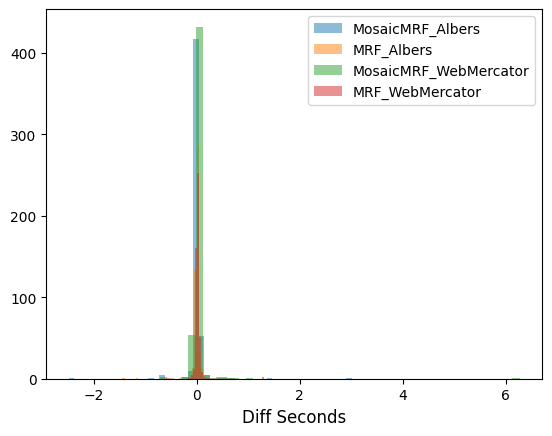

In [5]:
t = pandas.read_csv(exportImageTable)
# print(t)
plots = []
for service_name in list(image_services.keys()):
    field_list = []
    for projection_name in projections.keys():
        field_name = '{} Projection-{} Time'.format(service_name,projection_name)
        field_list.append(field_name)
    print(field_list)
    diff = t[field_list[0]]-t[field_list[1]]
    mean = numpy.mean(diff)
    mae = numpy.mean(numpy.absolute(diff))
    rmse = numpy.sqrt(numpy.mean(numpy.square(diff)))
    std = numpy.std(diff)
    print('Mean diff:',mean)
    print('MAE:',mae)
    print('RMSE:',rmse)
    print('STDev:',std)
    ttest = scipy.stats.ttest_ind(t[field_list[0]], t[field_list[1]], axis=0, equal_var=False, nan_policy='propagate', permutations=500, random_state=None, alternative='two-sided', trim=0)
    print(ttest)
#     t.plot.scatter(field_list[0],field_list[1],alpha=0.5)
    plt.hist(diff,50,alpha=0.5,label=service_name,density=False)
plt.legend()
plt.xlabel("Diff Seconds", size=12)
# plt.xlim(-.5,0.5)
#     print(t[field_list])

#     plots.append(plt.hist(t[field_list]))
    
# print(plots)